# Sentiment Classifier using a Dense Neural Network

> Classification of IMDB Reviews 

In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint

In [63]:
import os
from sklearn.metrics import roc_auc_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

## Hyper Parameter choices

In [47]:
out_dir = 'model_out/dense/'
epochs = 10
batch_size = 128 
n_dim = 64
n_unique = 5000
n_skip = 50
max_review = 100
pad_type = trunc_type = 'pre'

## Loading the Data

In [9]:
(x_train, y_train), (x_valid, y_valid) = imdb.load_data(num_words=n_unique, skip_top=n_skip)

In [10]:
x_train = np.asarray(x_train)
y_train = np.asanyarray(y_train)

In [11]:
print(x_train.shape,y_train.shape)

(25000,) (25000,)


## Words from index

In [12]:
word_index = imdb.get_word_index()

In [13]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["PAD"] = 0
word_index["START"] = 1
word_index["UNK"] = 2

In [14]:
word_index

{'fawn': 34704,
 'tsukino': 52009,
 'nunnery': 52010,
 'sonja': 16819,
 'vani': 63954,
 'woods': 1411,
 'spiders': 16118,
 'hanging': 2348,
 'woody': 2292,
 'trawling': 52011,
 "hold's": 52012,
 'comically': 11310,
 'localized': 40833,
 'disobeying': 30571,
 "'royale": 52013,
 "harpo's": 40834,
 'canet': 52014,
 'aileen': 19316,
 'acurately': 52015,
 "diplomat's": 52016,
 'rickman': 25245,
 'arranged': 6749,
 'rumbustious': 52017,
 'familiarness': 52018,
 "spider'": 52019,
 'hahahah': 68807,
 "wood'": 52020,
 'transvestism': 40836,
 "hangin'": 34705,
 'bringing': 2341,
 'seamier': 40837,
 'wooded': 34706,
 'bravora': 52021,
 'grueling': 16820,
 'wooden': 1639,
 'wednesday': 16821,
 "'prix": 52022,
 'altagracia': 34707,
 'circuitry': 52023,
 'crotch': 11588,
 'busybody': 57769,
 "tart'n'tangy": 52024,
 'burgade': 14132,
 'thrace': 52026,
 "tom's": 11041,
 'snuggles': 52028,
 'francesco': 29117,
 'complainers': 52030,
 'templarios': 52128,
 '272': 40838,
 '273': 52031,
 'zaniacs': 52133,

In [15]:
index_word = {v:k for k,v in word_index.items()}

In [16]:
sent = ' '.join(index_word[i] for i in x_train[0])
sent

"UNK UNK UNK UNK UNK brilliant casting location scenery story direction everyone's really suited UNK part UNK played UNK UNK could UNK imagine being there robert UNK UNK UNK amazing actor UNK now UNK same being director UNK father came UNK UNK same scottish island UNK myself UNK UNK loved UNK fact there UNK UNK real connection UNK UNK UNK UNK witty remarks throughout UNK UNK were great UNK UNK UNK brilliant UNK much UNK UNK bought UNK UNK UNK soon UNK UNK UNK released UNK UNK UNK would recommend UNK UNK everyone UNK watch UNK UNK fly UNK UNK amazing really cried UNK UNK end UNK UNK UNK sad UNK UNK know what UNK say UNK UNK cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done do

In [17]:
(all_x_tr,_),(all_x_val,_) = imdb.load_data()

In [18]:
all_sent = ' '.join(index_word[i] for i in all_x_tr[0])

In [19]:
all_sent

"START this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert redford's is an amazing actor and now the same being director norman's father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for retail and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also congratulations to the two little boy's that played the part's of norman and paul they were just brilliant children are often left out of the praising list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and shou

## Preprocessing

In [20]:
x_train = pad_sequences(x_train,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

In [21]:
x_valid = pad_sequences(x_valid,maxlen=max_review,padding=pad_type,truncating=trunc_type, value=0)

In [22]:
x_train.shape

(25000, 100)

In [23]:
sent = ' '.join(index_word[i] for i in x_train[0])
sent

"cry UNK UNK UNK UNK must UNK been good UNK UNK definitely UNK also UNK UNK UNK two little UNK UNK played UNK UNK UNK norman UNK paul UNK were UNK brilliant children UNK often left UNK UNK UNK UNK list UNK think because UNK stars UNK play them UNK grown up UNK such UNK big UNK UNK UNK whole UNK UNK these children UNK amazing UNK should UNK UNK UNK what UNK UNK done don't UNK think UNK whole story UNK UNK lovely because UNK UNK true UNK UNK someone's life after UNK UNK UNK UNK UNK us UNK"

## Deepnet Architecture

In [24]:
def modeler(n_dense=64,n_drop=0.5):
    model = Sequential()
    model.add(Embedding(n_unique,n_dim,input_length=max_review))
    model.add(Flatten())
    model.add(Dense(n_dense,activation='relu'))
    model.add(Dropout(n_drop))
    model.add(Dense(1,activation='sigmoid'))
    model.summary()
    return model

In [25]:
model = modeler()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 64)           320000    
_________________________________________________________________
flatten (Flatten)            (None, 6400)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                409664    
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 729,729
Trainable params: 729,729
Non-trainable params: 0
_________________________________________________________________


In [29]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [30]:
modelcheckpoint = ModelCheckpoint(filepath=out_dir+"weights.{epoch:02d}.hdf5")

In [31]:
if not os.path.exists(out_dir):
    os.makedirs(out_dir)

## Training the Model

In [33]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[modelcheckpoint])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 3s 100us/sample - loss: 0.5324 - accuracy: 0.7112 - val_loss: 0.3461 - val_accuracy: 0.8483
Epoch 2/10
25000/25000 [==============================] - 2s 90us/sample - loss: 0.2594 - accuracy: 0.8990 - val_loss: 0.3541 - val_accuracy: 0.8443
Epoch 3/10
25000/25000 [==============================] - 2s 89us/sample - loss: 0.0939 - accuracy: 0.9754 - val_loss: 0.4459 - val_accuracy: 0.8295
Epoch 4/10
25000/25000 [==============================] - 2s 82us/sample - loss: 0.0185 - accuracy: 0.9980 - val_loss: 0.5362 - val_accuracy: 0.8337
Epoch 5/10
25000/25000 [==============================] - 2s 82us/sample - loss: 0.0057 - accuracy: 0.9998 - val_loss: 0.5968 - val_accuracy: 0.8363
Epoch 6/10
25000/25000 [==============================] - 2s 87us/sample - loss: 0.0025 - accuracy: 0.9999 - val_loss: 0.6456 - val_accuracy: 0.8366
Epoch 7/10
25000/25000 [==============================]

## Tensorboard Support

In [43]:
from tensorflow.keras.callbacks import TensorBoard
from time import time

In [45]:
tensorboard = TensorBoard(log_dir=out_dir+"/tdb/"+"logs/{}".format(time()))

In [46]:
model.fit(x_train,y_train,batch_size=batch_size,epochs=epochs,verbose=1,validation_data=(x_valid,y_valid),callbacks=[tensorboard])

Train on 25000 samples, validate on 25000 samples
Epoch 1/10
25000/25000 [==============================] - 2s 78us/sample - loss: 3.8801e-04 - accuracy: 1.0000 - val_loss: 0.7919 - val_accuracy: 0.8368
Epoch 2/10
25000/25000 [==============================] - 2s 78us/sample - loss: 3.0828e-04 - accuracy: 1.0000 - val_loss: 0.8175 - val_accuracy: 0.8373
Epoch 3/10
25000/25000 [==============================] - 2s 80us/sample - loss: 2.4906e-04 - accuracy: 1.0000 - val_loss: 0.8403 - val_accuracy: 0.8368
Epoch 4/10
25000/25000 [==============================] - 2s 74us/sample - loss: 2.0380e-04 - accuracy: 1.0000 - val_loss: 0.8559 - val_accuracy: 0.8370
Epoch 5/10
25000/25000 [==============================] - 2s 76us/sample - loss: 1.8183e-04 - accuracy: 1.0000 - val_loss: 0.8734 - val_accuracy: 0.8372
Epoch 6/10
25000/25000 [==============================] - 2s 77us/sample - loss: 1.4817e-04 - accuracy: 1.0000 - val_loss: 0.8925 - val_accuracy: 0.8366
Epoch 7/10
25000/25000 [========

In [54]:
#! tensorboard --logdir=model_out/dense/tdb/logs/

In [58]:
model.load_weights(out_dir+'denseweights.02.hdf5')

In [60]:
y_hat = model.predict_proba(x_valid,verbose=1)

25000/25000 [==============================] - 1s 31us/sample


In [61]:
y_hat[0]

array([0.1356923], dtype=float32)

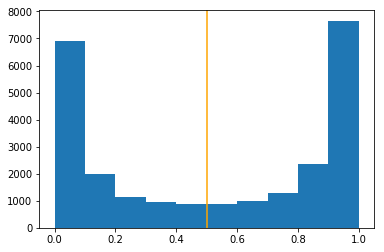

In [64]:
plt.hist(y_hat)
_ = plt.axvline(x=0.5,color = 'orange')

In [67]:
pct = roc_auc_score(y_valid,y_hat)*100.0

In [69]:
"{:0.2f}".format(pct)

'92.52'

In [76]:
def dfr(y_hat):
    y =[]
    for i in y_hat:
        y.append(i[0])
    return y

In [77]:
y_df = dfr(y_hat)

In [81]:
ydf = pd.DataFrame(list(zip(y_df,y_valid)),columns=['y_pred','y_valid'])

In [83]:
ydf.head(10)

,y_pred,y_valid
0,0.135692,0
1,0.980160,1
2,0.765728,1
3,0.834505,0
4,0.995271,1
5,0.837573,1
6,0.932543,1
7,0.021898,0
8,0.806966,0
9,0.808845,1


In [88]:
' '.join(index_word[i] for i in all_x_val[3])

"START i generally love this type of movie however this time i found myself wanting to kick the screen since i can't do that i will just complain about it this was absolutely idiotic the things that happen with the dead kids are very cool but the alive people are absolute idiots i am a grown man pretty big and i can defend myself well however i would not do half the stuff the little girl does in this movie also the mother in this movie is reckless with her children to the point of neglect i wish i wasn't so angry about her and her actions because i would have otherwise enjoyed the flick what a number she was take my advise and fast forward through everything you see her do until the end also is anyone else getting sick of watching movies that are filmed so dark anymore one can hardly see what is being filmed as an audience we are impossibly involved with the actions on the screen so then why the hell can't we have night vision"